# Network stress FC analysis

This analysis works to determine the impact on stress centrality upon deletion of specific nodes.

## Modules

In [2]:
library(ggplot2)
library(tidyverse)
library(igraph)
library(dplyr)

## Functions

In [3]:
gene_stress <- function(g){
    require(igraph)
    require(sna)
    require(tidyverse)
    
    m <- g %>% as_adjacency_matrix(names = TRUE, sparse = FALSE)
    val <- m %>% stresscent()
    data.frame(entrez = colnames(m), stress = val)
}

## Import network

In [4]:
edges <- suppressMessages(read_tsv("MLL-AF4/AggregatedGraph_MLL-AF4_edges.tsv"))
nodes <- suppressMessages(read_tsv("MLL-AF4/AggregatedGraph_MLL-AF4_nodes.tsv"))

In [5]:
graph <- graph_from_data_frame(edges, directed = T, vertices = nodes)

## RUNX1 deletion & stress recalculation

In [6]:
graph_RUNX1_del <- delete_vertices(graph, which(V(graph)$symbol == "RUNX1"))

In [8]:
centralities <- graph_RUNX1_del %>% 
    gene_stress()

In [9]:
graph_RUNX1_del <- set_vertex_attr(graph_RUNX1_del, "stress_RUNX1_del", value=centralities$stress)

In [10]:
nodes_RUNX1_del <- igraph::as_data_frame(graph_RUNX1_del, what = "vertices")

In [11]:
head(nodes_RUNX1_del)

,name,symbol,degree,stress,MLL.AF4.logFC,MLL.AF4.FDR,RUNX1.logFC,RUNX1.FDR,UNC1999.logFC,UNC1999.FDR,EPZ.logFC,EPZ.FDR,IBET.logFC,IBET.FDR,Dropout_class,stress_RUNX1_del
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1958,1958,EGR1,464,29049,0.9345442,6.735290e-16,-1.0546494,4.563840e-09,0.45937833,2.877195e-02,-0.7559783,1.372324e-05,1.7365483,1.391195e-46,non-dropout,25161
2355,2355,FOSL2,217,7404,-0.5205269,4.731414e-25,-0.4224753,6.221770e-07,0.09406331,4.265643e-01,-0.2676087,1.203066e-01,-0.2068572,8.249632e-04,non-dropout,5264
405,405,ARNT,559,7646,0.2374961,4.145152e-04,0.1046306,2.771233e-01,-0.08307452,4.760320e-01,0.2652957,1.605366e-01,-0.3973892,3.360668e-06,non-leukemia-specific dropout,8331
4609,4609,MYC,1154,89851,-0.2487874,4.125718e-05,-0.1012395,4.123907e-01,-0.87270226,1.582076e-18,-0.8124231,6.623918e-08,-1.5108634,2.265482e-127,non-leukemia-specific dropout,87477
6239,6239,RREB1,319,15594,0.2578800,6.073601e-06,0.1526835,3.948804e-02,0.21473278,4.552598e-03,-0.1876350,2.789407e-01,-0.2671828,1.356396e-05,non-dropout,14533
6772,6772,STAT1,404,21662,0.2396495,6.305926e-04,-0.1175383,1.256426e-01,0.19241110,1.124953e-02,-0.2185313,2.135825e-01,0.6186133,2.332276e-25,non-dropout,23567


## Plotting

### Scatter plot using stress calculation post-RUNX1 deletion

In [17]:
point_type <- 16
size_scale <-1.5

p.R1_del <- ggplot(nodes_RUNX1_del, aes(x=degree, y=stress_RUNX1_del)) +
    geom_point(data=nodes_RUNX1_del, pch=point_type, cex=size_scale) +
    geom_text(aes(label=symbol), data=subset(nodes_RUNX1_del, stress > 20000 | degree > 450), nudge_y = 1250) +
    theme_classic() + 
    theme(legend.position = "none") +
    ggtitle("Centrality distribution after RUNX1 deletion")

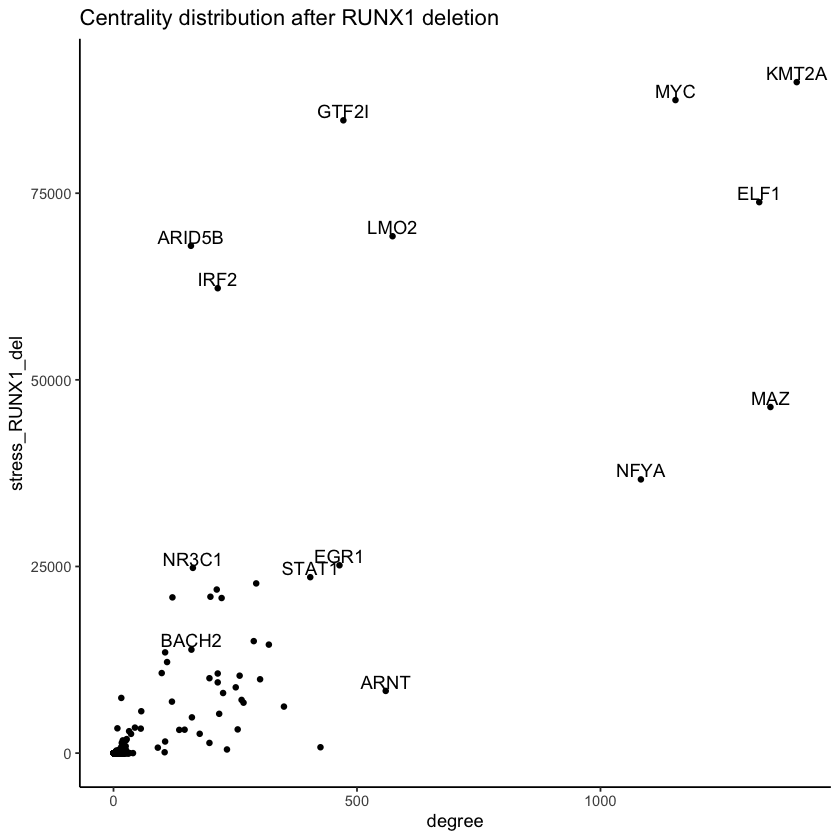

In [18]:
p.R1_del

## Stress change calculation

In [23]:
# Remove nodes with no stress (e.g, end-point nodes)
nodes_non_zero <- nodes_RUNX1_del[nodes_RUNX1_del$stress != 0,]

#Calculate stress foldchange
nodes_non_zero$stress_FC <- (nodes_non_zero$stress_RUNX1_del - nodes_non_zero$stress)/nodes_non_zero$stress

#Annotate change change in stress
nodes_non_zero$stress_direction <- rep("unchanged", nrow(nodes_non_zero))
nodes_non_zero$stress_direction[nodes_non_zero$stress_FC > 0.1] <- "increased"
nodes_non_zero$stress_direction[nodes_non_zero$stress_FC < -0.1] <- "decreased"


In [24]:
head(nodes_non_zero)

,name,symbol,degree,stress,MLL.AF4.logFC,MLL.AF4.FDR,RUNX1.logFC,RUNX1.FDR,UNC1999.logFC,UNC1999.FDR,EPZ.logFC,EPZ.FDR,IBET.logFC,IBET.FDR,Dropout_class,stress_RUNX1_del,stress_FC,stress_direction
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1958,1958,EGR1,464,29049,0.9345442,6.735290e-16,-1.0546494,4.563840e-09,0.45937833,2.877195e-02,-0.7559783,1.372324e-05,1.7365483,1.391195e-46,non-dropout,25161,-0.13384282,decreased
2355,2355,FOSL2,217,7404,-0.5205269,4.731414e-25,-0.4224753,6.221770e-07,0.09406331,4.265643e-01,-0.2676087,1.203066e-01,-0.2068572,8.249632e-04,non-dropout,5264,-0.28903296,decreased
405,405,ARNT,559,7646,0.2374961,4.145152e-04,0.1046306,2.771233e-01,-0.08307452,4.760320e-01,0.2652957,1.605366e-01,-0.3973892,3.360668e-06,non-leukemia-specific dropout,8331,0.08958933,unchanged
4609,4609,MYC,1154,89851,-0.2487874,4.125718e-05,-0.1012395,4.123907e-01,-0.87270226,1.582076e-18,-0.8124231,6.623918e-08,-1.5108634,2.265482e-127,non-leukemia-specific dropout,87477,-0.02642152,unchanged
6239,6239,RREB1,319,15594,0.2578800,6.073601e-06,0.1526835,3.948804e-02,0.21473278,4.552598e-03,-0.1876350,2.789407e-01,-0.2671828,1.356396e-05,non-dropout,14533,-0.06803899,unchanged
6772,6772,STAT1,404,21662,0.2396495,6.305926e-04,-0.1175383,1.256426e-01,0.19241110,1.124953e-02,-0.2185313,2.135825e-01,0.6186133,2.332276e-25,non-dropout,23567,0.08794202,unchanged


### Plotting

In [21]:
point_type <- 16
size_scale <-1.5

p.stress_FC <- ggplot(nodes_non_zero, aes(y=(stress_FC), x=degree, col=stress_direction)) +
    geom_point(data=nodes_non_zero, pch=point_type, cex=size_scale) +
    geom_text(aes(label=symbol), data=subset(nodes_non_zero, abs(stress_FC) > 0.2 | degree > 450), nudge_x = 70) +
    scale_color_manual(values=c("increased" = "blue", "decreased" = "red", "unchanged" = "grey60")) + 
    theme_classic() + 
    theme(legend.position = "none") +

    ggtitle("Stress FC after RUNX1 deletion")

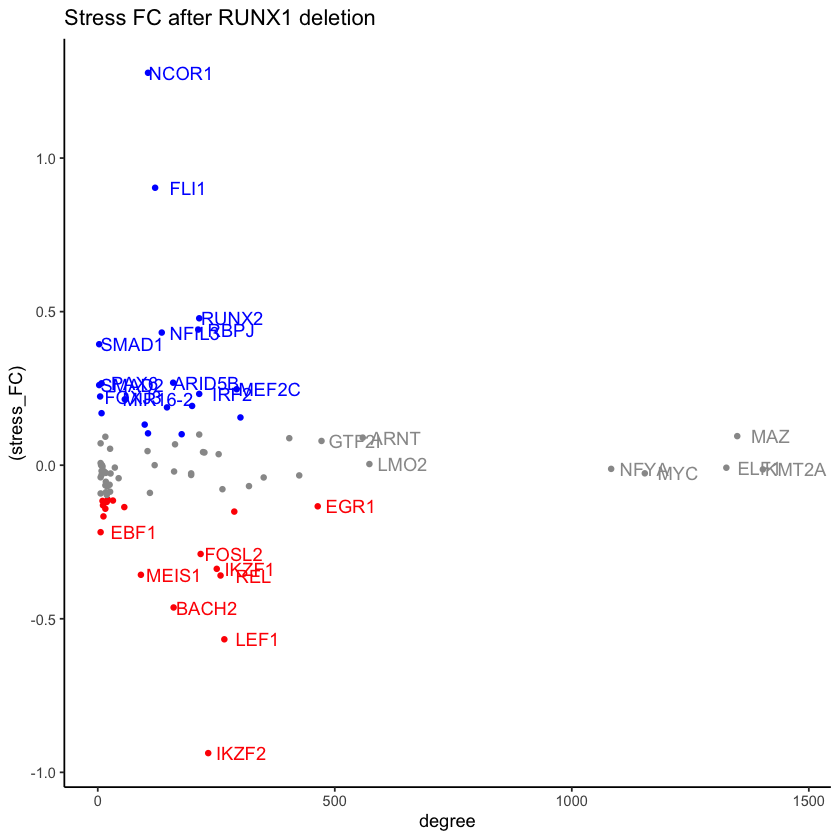

In [25]:
p.stress_FC

## Export

In [26]:
ggsave("Stress-vs-degree.pdf", p.standard, device="pdf", width = 4, height = 4, units = "in",
       useDingbats = F)
ggsave("Stress-vs-degree_RUNX1_deletion.pdf", p.R1_del, device="pdf", width = 4, height = 4, units = "in",
       useDingbats = F)
ggsave("StressFC.pdf", p.stress_FC, device="pdf", width = 4, height = 4, units = "in",
       useDingbats = F)